(1) [Mix of Gaussian](https://pythonmachinelearning.pro/clustering-with-gaussian-mixture-models/).

(2) [GMM](https://towardsdatascience.com/how-to-code-gaussian-mixture-models-from-scratch-in-python-9e7975df5252).

(3) [Python Abstracted Classes](https://www.python-course.eu/python3_abstract_classes.php)

(4) [Gaussian mixture and EM algorithim-Recommended](https://jonathan-hui.medium.com/machine-learning-expectation-maximization-algorithm-em-2e954cb76959)

In [1]:
#import libraries
import pandas as pd
import numpy as np
from collections import Counter
from itertools import groupby
from operator import itemgetter
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from numpy.linalg import norm
from abc import ABC, abstractmethod 
import time

In [2]:
#Data fetcher 
class DataFetcher:
    """
    DataFetcher: Grabs all csv data as pandas dataframes.
    """
    def __init__(self, directory, X_name, Y_name, num_subsets ,SUBSETS = False):
        self.directory = directory
        self.X_name = X_name
        self.Y_name = Y_name
        self.SUBSETS = SUBSETS
        self.num_subsets = num_subsets
    
    # get training X path
    # return path of the training data

    def _getTrainingXPath(self):
        return "./%s/train%s.csv" % (self.directory, self.X_name)

    def _getTrainingYPath(self):
        return "./%s/train%s.csv" % (self.directory, self.Y_name)

    def _getTrainingXPathSubsets(self, subset_num):
        # 0 < subset <= 9
        return "./%s/train%s%d.csv" % (self.directory, self.X_name, (subset_num+1))

    # get training Y path
    # return path of traning labels
    def _getTrainingYPathSubsets(self, subset_num):
        # 0 < subset <= 9
        return "./%s/train%s%d.csv" % (self.directory, self.Y_name, (subset_num+1))

    # get all traning X Y as list of data frames
    def getAllTrainingXY(self):
        if self.SUBSETS:
            trainingX_dfs = []
            trainingY_dfs = []
            for i in range(self.num_subsets):
                trainingX_dfs.append(pd.read_csv(self._getTrainingXPathSubsets(i), header=None))
                trainingY_dfs.append(pd.read_csv(self._getTrainingYPathSubsets(i), header=None))
            return trainingX_dfs, trainingY_dfs
        else:
            trainingX_dfs = pd.read_csv(self._getTrainingXPath(), header=None)
            trainingY_dfs = pd.read_csv(self._getTrainingYPath(), header=None)


    # #get test X Y as list of data frames
    def getAllTestXY(self):
        testX_path = "./%s/test%s.csv" % (self.directory, self.X_name)
        testY_path = "./%s/test%s.csv" % (self.directory, self.Y_name)
        testX_df = pd.read_csv(testX_path, header=None)
        testY_df = pd.read_csv(testY_path, header=None)
        return testX_df, testY_df

#data = DataFetcher('Knn-dataset', 'Data', 'Labels')

In [3]:
#Data Fetcher Testing
dir = 'Knn-dataset'
X_name = 'Data'
Y_name = 'Labels'
fetcher = DataFetcher(dir, X_name, Y_name, 10, SUBSETS = True) 
training_x_dfs, training_y_dfs = fetcher.getAllTrainingXY()
testing_x_df, testing_y_df = fetcher.getAllTestXY()

print(f"Number of folds = {np.asarray(training_x_dfs).shape[0]}")
print(f"Number of Exambles per fold = {np.asarray(training_x_dfs).shape[1]}")
print(f"Number of Exambles Features = {np.asarray(training_x_dfs).shape[2]}")



Number of folds = 10
Number of Exambles per fold = 100
Number of Exambles Features = 64


In [32]:
print("Examble of training data:")
training_x_dfs[0].head()


Examble of training data:


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0,0,11,0,16,0,0,0,4,0,...,0,0,0,0,0,0,3,5,0,0
1,0,0,9,16,16,16,0,0,0,0,...,5,0,3,0,15,13,10,3,0,16
2,9,16,15,10,16,16,0,0,16,13,...,16,16,0,16,16,7,16,16,16,3
3,0,0,0,6,0,1,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
4,0,5,0,14,16,0,0,0,0,0,...,15,0,0,3,0,9,0,8,0,0


In [46]:
print("Examble of training Labels:")
training_y_dfs[0].head()

Examble of training Labels:


,0
0,6
1,5
2,6
3,5
4,6


In [54]:
# Cross Validation
class CrossValidation:
    def __init__(self, x_dfs, y_dfs): 
        self.X = x_dfs
        self.Y = y_dfs
        self.subsets_num = len(x_dfs) #length of dataframes is K folds.

        #split training validation
        #pick one subset for validation and the rest for training(used for both X, and Y)
    def _splitTrainingValidation(self, dfs, subset_num):

        validation_df = dfs[subset_num]         #get a single fold as a validtion set 

        training_df = dfs[:subset_num] + dfs[subset_num+1:]     #The reset of dataframes are the training sets.
        #do not use the index values along the concatenation axis. 
        #The resulting axis will be labeled 0, …, n - 1 
        #Output will be as a single df
        training_df = pd.concat(training_df, ignore_index=True)         

        return training_df, validation_df


        #get training validation X
    def _getTrainingValidationX(self, subset_num):
        training_X, validation_X = self._splitTrainingValidation(self.X, subset_num)
        return training_X, validation_X

        #get training validation Y
    def _getTrainingValidationY(self, subset_num):
        training_Y, validation_Y = self._splitTrainingValidation(self.Y, subset_num)
        return training_Y, validation_Y

        #get training validation XY 
    def getTrainingValidationXY(self, subset_num):
        training_X, validation_X = self._getTrainingValidationX(subset_num)
        training_Y, validation_Y = self._getTrainingValidationY(subset_num)

        return [training_X, training_Y, validation_X, validation_Y]
            

        #get all X Y
    def getAllXY(self):
        training_X = pd.concat(self.X, ignore_index=True)
        training_Y = pd.concat(self.Y, ignore_index=True)

        return [training_X, training_Y]

def getAccuracy(actual_y, predicted_y):
    assert(actual_y.__len__()==predicted_y.__len__())
    accuracy = sum(1 for y, y_hat in zip(actual_y, predicted_y) if y == y_hat)/len(actual_y)
    return accuracy

In [55]:
#model class
class Model(ABC):
    def __init__(self, train_x, train_y):
        self.X = train_x
        self.Y = train_y
    
    @classmethod
    def predict(self, x):
        pass

    def predict_df(self, X_df):
        predictions = X_df.apply(lambda row: self.predict(row), raw=True, axis=1)
        return predictions

In [56]:
#importing data 
DIR_NAME = 'knn-dataset'
X_NAME = 'Data'
Y_NAME = 'Labels'
NUM_SUBSETS = 10
POSITIVE_LABEL = 6
SUBSETS = True
NEGATIVE_LABEL = 5
LAMBDAS = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000]

In [60]:
#test data
DF = DataFetcher(DIR_NAME, X_NAME, Y_NAME, NUM_SUBSETS, True)
test_X, test_Y = DF.getAllTestXY()
test_X.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0,0,0,1,13,10,0,0,0,8,...,16,0,0,0,4,0,14,0,15,0
1,0,0,0,0,0,7,0,0,0,0,...,16,0,0,0,0,0,2,11,12,0
2,16,11,5,16,15,16,16,16,16,16,...,14,16,16,16,16,16,16,16,16,0
3,0,0,7,16,2,2,0,0,0,1,...,11,0,0,0,0,9,9,0,0,0
4,0,0,0,7,0,0,0,0,0,0,...,0,0,0,0,0,13,14,12,0,0


In [61]:
test_Y.head()

,0
0,6
1,6
2,5
3,6
4,6


In [62]:
#training validation split
training_X_dfs, training_Y_dfs = DF.getAllTrainingXY()
CVData = CrossValidation(training_X_dfs, training_Y_dfs)
print("Training X shape:"+ str(CVData.getTrainingValidationXY(0)[0].shape))

Training X shape:(900, 64)


In [63]:
print("Tarining Y shape:"+ str(CVData.getTrainingValidationXY(0)[1].shape))

Tarining Y shape:(900, 1)


In [64]:
print("Validation X shape:"+ str(CVData.getTrainingValidationXY(0)[2].shape))

Validation X shape:(100, 64)


In [65]:
print("Validation Y shape:"+ str(CVData.getTrainingValidationXY(0)[3].shape))

Validation Y shape:(100, 1)


In [66]:
# Mixture of Gaussian 
class MixtureOfGaussian(Model):
    def __init__(self, train_x, train_y, positive_label, negative_label):
        super().__init__(train_x, train_y)
        self.positive_label = positive_label
        self.negative_label = negative_label
        
    
        # MLE Estimation for parameters
        
        y_list = train_y.values.flatten().tolist() #convert df to seq list

        pi = sum([1 if y == self.positive_label else 0 for y in y_list])/len(y_list)   # pi = summation-n(yn/N)


        #calculate mu1, mu2, s1, s2, cov, inv_cov
        
        positive_indices = [ind for ind, y in enumerate(y_list) if y == positive_label]
        negative_indices = [ind for ind, y in enumerate(y_list) if y != positive_label] 

        n1 = len(positive_indices)
        n2 = len(negative_indices)

        N = n1 + n2

        positive_X_df = train_x.iloc[positive_indices]
        negative_X_df = train_x.iloc[negative_indices]

        mu1 = positive_X_df.mean(axis=0)
        mu2 = negative_X_df.mean(axis=0)

        positive_X = positive_X_df.to_numpy()
        negative_X = negative_X_df.to_numpy()

        positive_dists = positive_X_df.to_numpy() - mu1.to_numpy()
        negative_dists = negative_X_df.to_numpy() - mu2.to_numpy()

        s1 = positive_dists.T.dot(positive_dists) / n1
        s2 = positive_dists.T.dot(positive_dists) / n2

        cov = (n1/N) * s1 + (n2/N) * s2
        cov_inv = np.linalg.inv(cov)

        w = cov_inv.dot(mu1 - mu2)
        w_0 = -(1/2) * mu1.T.dot(cov_inv).dot(mu1) + (1/2) * mu2.T.dot(cov_inv).dot(mu2) + np.log(pi/ (1-pi))

        self.pi = pi
        self.n1 = n1
        self.n2 = n2
        self.mu1 = mu1
        self.mu2 = mu2
        self.cov = cov
        self.w = w
        self.w_0 = w_0 

    def predict_prob(self, x):
        logit_odds = self.w.dot(x) + self.w_0
        prob = 1 / (1 + np.exp(-logit_odds))        
        return prob
    
    def predict(self, x):
        prob = self.predict_prob(x)
        if prob > 0.5:
            return self.positive_label
        else:
            return self.negative_label



In [67]:
#train and test 
train_x, train_y = CVData.getAllXY()

# Create hypothesis
t1 = time.time()
model = MixtureOfGaussian(train_x, train_y, POSITIVE_LABEL, NEGATIVE_LABEL)
t2 = time.time()

# Train Accuracy 
predicted_train_y = model.predict_df(train_x)
train_accuracy = getAccuracy(train_y.values.flatten(), predicted_train_y.values.flatten())

# Test Accuracy
predicted_test_y = model.predict_df(test_X)
test_accuracy = getAccuracy(test_Y.values.flatten(), predicted_test_y.values.flatten())


print("Train Accuracy: %f" % train_accuracy)
print("Test Accuracy: %f" % test_accuracy)
print("Training Time: " + str(t2-t1))

Train Accuracy: 0.836000
Test Accuracy: 0.854545
Training Time: 0.03766155242919922


## Logistic Regression Model

In [68]:
class LogisticRegressionModel(Model):
    def __init__(self, train_X, train_y, positive_label, negative_label, lmbda=0,  max_iters=10, threshold=0.01, train_intercept=True):
        super().__init__(train_X, train_y)
        self.positive_label = positive_label
        self.negative_label = negative_label
        self.lmbda = lmbda
        self.max_iters = max_iters
        self.threshold = threshold
        self.train_intercept = train_intercept

        X = train_X.to_numpy()
        y = train_y.to_numpy()

        # y's as 1 & 0's
        y = [1 if y_i == positive_label else 0 for y_i in y]

        # Add column of ones
        if train_intercept:
            X = np.insert(X, 0, np.ones(len(X)), axis=1)

        self.X = X                                  #(1000, 64) Shape
        self.y = y                                  #(1000,1) Shape

        self.w = np.zeros(X.shape[1])               #(64,) Shape
        
        self._train(self.X, self.w, self.y)        

    def _sigmoid(self, odds):
        return 1 / 1 + np.exp(-odds)                
        
    def _gradient(self, X, w, y):
        weighted_values = X.dot(w)
        # probabiliteis = np.apply_along_axis(self._sigmoid, 0, weighted_values)
        probabiliteis = self._sigmoid(weighted_values)#faster 4X than using apply_along_axis
        return X.T.dot(probabiliteis-y) + 0.5 * self.lmbda * w.T.dot(w)

    def _invProbability(self, probability):
        return 1-probability

    def _R(self, X, w):
        weighted_values = X.dot(w)
        probabilities = self._sigmoid(weighted_values)
        inv_probabilities = self._invProbability(weighted_values)
        return np.diag(np.multiply(probabilities, inv_probabilities))

    def _Hassian(self, X, w):
        R = self._R(X, w)
        H = X.T.dot(R).dot(X)
        return H + self.lmbda * np.identity(len(H))
        
    def _train(self, X, w, y):
        iters = 0 
        while (True):
            if iters >= self.max_iters:
                break

            gradient = self._gradient(X, w, y)
            hassian = self._Hassian(X, w)
            hassian_inv = np.linalg.inv(hassian)

            w_new = w - hassian_inv.dot(gradient)

            dist = norm(w_new - w)

            w = w_new

            if dist < self.threshold:
                break

            iters += 1
        self.w = w 
        
    def predict_prob(self, x):
        if self.train_intercept:
            x = np.insert(x, 0, 1)
        odds = self.w.dot(x) 
        return self._sigmoid(odds)
    
def predict(self, x):
    prob = self.predict_prob(x)
    if prob > 0.5:
        return self.positive_label
    else:
        return self.negative_label

        

## Cross Validation

In [69]:
import tqdm
def perform_logreg_CV():

    average_accuracies = []
    for lmbda in tqdm_notebook(LAMBDAS):
        # Perform CV
        accuracies = []
        for j in range(NUM_SUBSETS):
            train_X, train_y, validation_X, validation_y = CVData.getTrainingValidationXY(j)
            
            # Create hypothesis
            model = LogisticRegressionModel(train_X, train_y, POSITIVE_LABEL, NEGATIVE_LABEL, lmbda)
            predicted_validation_y = model.predict_df(validation_X)

            # Get accuracy
            accuracy = getAccuracy(validation_y.values.flatten(), predicted_validation_y.values.flatten())
            accuracies.append(accuracy)

        avg_accuracy = np.mean(accuracies)
        average_accuracies.append(avg_accuracy)

    return average_accuracies


## Finding Optimal Lambda 

In [70]:
cv_accuracies = perform_logreg_CV()
optimal_lambda = LAMBDAS[np.argsort(cv_accuracies)[-1]]
print("The optimal lambda is %f with an average accuracy of %f" % (optimal_lambda, max(cv_accuracies)))

C:\Users\User\miniconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/15 [00:00<?, ?it/s]

The optimal lambda is 15000.000000 with an average accuracy of 0.000000


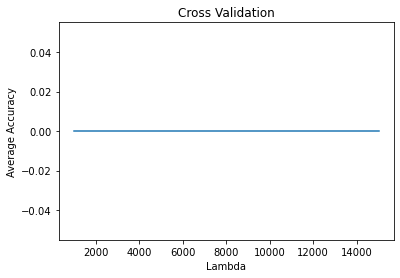

In [71]:
plt.plot(LAMBDAS, cv_accuracies)
plt.xlabel('Lambda')
plt.ylabel('Average Accuracy')
plt.title('Cross Validation')
plt.show()

In [178]:
training_data_x = train_x.to_numpy()
weights_random = np.random.rand(training_data_x.shape[1])
def sigmoid(odds):
            return 1 / 1 + np.exp(-odds)


In [171]:
weighted_values = training_data_x.dot(weights_random)


(1000,)

In [168]:
%timeit sigmoid(weighted_values)

8.01 µs ± 70.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [175]:
np.diag(np.multiply(sigmoid(weighted_values), sigmoid(weighted_values))).shape

(1000, 1000)

In [169]:
%timeit np.apply_along_axis(sigmoid, 0, weighted_values)

47.3 µs ± 828 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [135]:
def gradient(x, w, y):
    weighted_values = x.dot(w)
    square_part = sigmoid(weighted_values) - y 
    return square_part.T.dot(x)


In [156]:
%timeit gradients = gradient(training_data_x, weights_random, train_y.to_numpy())

5.19 ms ± 242 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [147]:
gradients = gradient(training_data_x, weights_random, train_y.to_numpy())
gradients.shape

(1000, 64)

In [144]:
def gradient_along_axis(x, w, y):
    weighted_values = x.dot(w)
    probabilities = np.apply_along_axis(sigmoid, 0, weighted_values)
    return (probabilities-y).T.dot(x)

In [154]:
%timeit gradient_along_axis(training_data_x, weights_random, train_y.to_numpy())

7.12 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [153]:
gradients_2 = gradient_along_axis(training_data_x, weights_random, train_y.to_numpy())
gradients_2.shape

(1000, 64)